In [1]:
import pandas as pd
import numpy as np
import pickle
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import sys
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Amazon Sale 2023/All Electronics.csv')

In [4]:
data.head(5)

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965,"₹10,999","₹18,999"
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,"113,956","₹18,999","₹19,999"
2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,"90,304","₹1,999","₹2,299"
3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yj...,https://www.amazon.in/Samsung-Mystique-Storage...,4.1,"24,863","₹15,999","₹24,999"
4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUI...,https://www.amazon.in/OnePlus-Nord-Black-128GB...,4.3,"113,956","₹18,999","₹19,999"


In [5]:
pd.set_option('display.max_colwidth', None)
data['name'][9579]


'Ambrane 18W BoostedSpeed™ Charger with USB Port & Quick Charge, Made in India, Multi-Layer Protection, iPhone & Android Co...'

In [6]:
data.shape

(9600, 9)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            9600 non-null   object
 1   main_category   9600 non-null   object
 2   sub_category    9600 non-null   object
 3   image           9600 non-null   object
 4   link            9600 non-null   object
 5   ratings         9505 non-null   object
 6   no_of_ratings   9505 non-null   object
 7   discount_price  9116 non-null   object
 8   actual_price    9530 non-null   object
dtypes: object(9)
memory usage: 675.1+ KB


In [8]:
data.isnull().sum()

name                0
main_category       0
sub_category        0
image               0
link                0
ratings            95
no_of_ratings      95
discount_price    484
actual_price       70
dtype: int64

In [9]:
# Droping the columns with 70% or more missing data
perc = 70.0
min_count =  int(((100 - perc)/100) * data.shape[1] + 1)
mod_df = data.dropna(axis = 1, thresh = min_count)


In [10]:
mod_df.columns

Index(['name', 'main_category', 'sub_category', 'image', 'link', 'ratings',
       'no_of_ratings', 'discount_price', 'actual_price'],
      dtype='object')

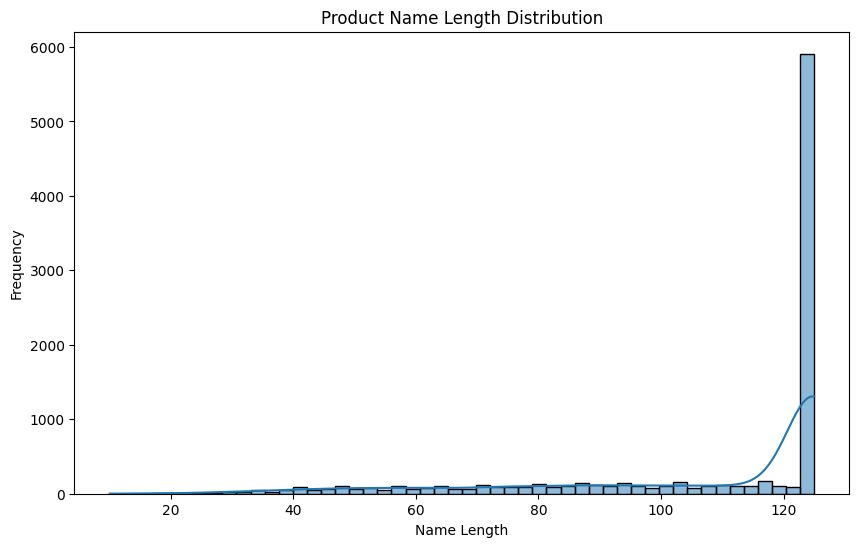

In [11]:
data['name_length'] = data['name'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data['name_length'], bins=50, kde=True)
plt.title('Product Name Length Distribution')
plt.xlabel('Name Length')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='no_of_ratings', ylabel='Count'>

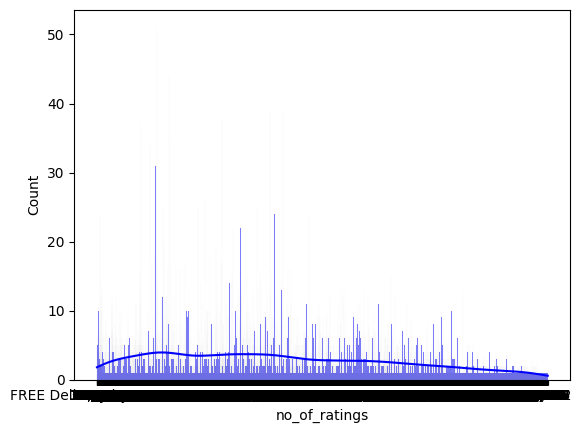

In [12]:
sns.histplot(data=data, x='no_of_ratings', bins=30, kde=True, color='blue')

<Axes: xlabel='count', ylabel='ratings'>

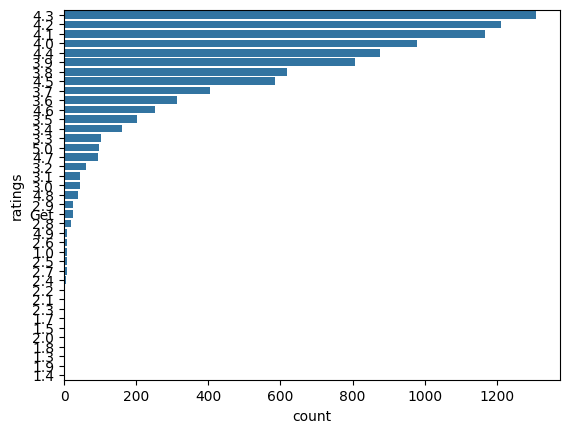

In [13]:
sns.countplot(y='ratings', data=data, order=data['ratings'].value_counts().index)

# Clean numeric columns and set data types


In [14]:
# Removing the ₹ sign
mod_df["discount_price"] = mod_df["discount_price"].str.split(" ", expand = True).get(0).str.split("₹", expand = True).get(1)
mod_df["actual_price"] = mod_df["actual_price"].str.split(" ", expand = True).get(0).str.split("₹", expand = True).get(1)


In [15]:
# Change commas to dots and change the type to float
mod_df['discount_price'] = mod_df["discount_price"].str.replace(',', '').astype(float)
mod_df["actual_price"] = mod_df["actual_price"].str.replace(',', '').astype(float)


In [16]:
#modify ratings value
mod_df["ratings"].unique()

array(['4.0', '4.3', '4.2', '4.1', '3.9', '4.6', '3.8', 'Get', '4.4',
       '3.5', '3.7', '4.5', '3.3', '3.6', '3.4', nan, '3.2', '2.9', '4.7',
       '5.0', '2.5', '2.8', '4.8', '3.1', '3.0', '2.3', '2.7', '2.4',
       '4.9', '1.7', '1.5', '2.6', '1.8', '1.3', '2.1', '1.9', '2.2',
       '1.0', '1.4', '2.0'], dtype=object)

In [17]:
# Extract the digits and change the type to float
mod_df['ratings'] = mod_df['ratings'].replace(['Get','FREE','₹68.99', '₹65','₹70', '₹100', '₹99', '₹2.99'], '0.0')
mod_df['ratings'] = mod_df["ratings"].astype(float)
mod_df['ratings'].unique()


array([4. , 4.3, 4.2, 4.1, 3.9, 4.6, 3.8, 0. , 4.4, 3.5, 3.7, 4.5, 3.3,
       3.6, 3.4, nan, 3.2, 2.9, 4.7, 5. , 2.5, 2.8, 4.8, 3.1, 3. , 2.3,
       2.7, 2.4, 4.9, 1.7, 1.5, 2.6, 1.8, 1.3, 2.1, 1.9, 2.2, 1. , 1.4,
       2. ])

In [18]:
# Add column 'correct_no_of_ratings' which value is 'True' if 'no_of_ratings' begins from digit
mod_df['no_of_ratings'] = mod_df['no_of_ratings'].astype(str)
mod_df['correct_no_of_ratings'] = pd.Series([mod_df['no_of_ratings'][x][0].isdigit() for x in range(len(mod_df['no_of_ratings']))])
# Drop columns with incorrect 'no_of_ratings'
mod_df = mod_df[mod_df['correct_no_of_ratings'] == True]
mod_df['correct_no_of_ratings'].value_counts()


correct_no_of_ratings
True    9481
Name: count, dtype: int64

In [19]:
mod_df["no_of_ratings"] = mod_df["no_of_ratings"].str.replace(',', '').astype(float)

<ipython-input-19-b376d5c94d17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df["no_of_ratings"] = mod_df["no_of_ratings"].str.replace(',', '').astype(float)


In [20]:
mod_df.head(5)

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,correct_no_of_ratings
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB Storage)","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJL._AC_UL320_.jpg,https://www.amazon.in/Redmi-Power-Black-128GB-Storage/dp/B09Y64H8VS/ref=sr_1_4?qid=1679133649&s=electronics&sr=1-4,4.0,965.0,10999.0,18999.0,True
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM, 128GB Storage)","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3VzqL._AC_UL320_.jpg,https://www.amazon.in/OnePlus-Nord-Lite-128GB-Storage/dp/B09WQYFLRX/ref=sr_1_5?qid=1679133649&s=electronics&sr=1-5,4.3,113956.0,18999.0,19999.0,True
2,"OnePlus Bullets Z2 Bluetooth Wireless in Ear Earphones with Mic, Bombastic Bass - 12.4 Mm Drivers, 10 Mins Charge - 20 Hrs...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCpL._AC_UL320_.jpg,https://www.amazon.in/Oneplus-Bluetooth-Wireless-Earphones-Bombastic/dp/B09TVVGXWS/ref=sr_1_6?qid=1679133649&s=electronics&sr=1-6,4.2,90304.0,1999.0,2299.0,True
3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 128GB Storage) | 6000mAh Battery | Upto 12GB RAM with RAM Plus | Travel Adapte...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yjL._AC_UL320_.jpg,https://www.amazon.in/Samsung-Mystique-Storage-Purchased-Separately/dp/B09TWGDY4W/ref=sr_1_7?qid=1679133649&s=electronics&sr=1-7,4.1,24863.0,15999.0,24999.0,True
4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM, 128GB Storage)","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUIL._AC_UL320_.jpg,https://www.amazon.in/OnePlus-Nord-Black-128GB-Storage/dp/B09WQY65HN/ref=sr_1_8?qid=1679133649&s=electronics&sr=1-8,4.3,113956.0,18999.0,19999.0,True


In [21]:
import plotly.express as px #for making interactive viz
# Plot the total missing values
x = mod_df.isnull().sum()

fig = px.bar(x, orientation = "h",  text_auto='.2s',
            color_discrete_sequence= ["#ff6b00"] * len(x))
fig.update_layout(
    title="<b>Missing Value Count</b>",
    xaxis_title="Total missing values",
    yaxis_title="Column Names",
    plot_bgcolor = "#ECECEC",
    showlegend=False
)
fig.show()


In [22]:
missing_no_of_ratings = mod_df[mod_df["actual_price"].isnull()]
missing_no_of_ratings.head(2)


,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,correct_no_of_ratings
80,"Samsung Galaxy M33 5G (Deep Ocean Blue, 6GB, 128GB Storage) | 6000mAh Battery | Upto 12GB RAM with RAM Plus | Travel Adapt...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81xvGbBFNhL._AC_UL320_.jpg,https://www.amazon.in/Samsung-Storage-6000mAh-Purchased-Separately/dp/B09TWDYSWQ/ref=sr_1_83?qid=1679133654&s=electronics&sr=1-83,4.1,24863.0,NaN,NaN,True
416,"realme TechLife Buds T100 Bluetooth Truly Wireless in Ear Earbuds with mic, AI ENC for Calls, Google Fast Pair, 28 Hours T...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/W/IMAGERENDERING_521856-T2/images/I/61q65Ob+nrL._AC_UL320_.jpg,https://www.amazon.in/realme-TechLife-Bluetooth-Wireless-Playback/dp/B0BQLWZLJX/ref=sr_1_418?qid=1679133675&s=electronics&sr=1-418,3.7,46.0,NaN,NaN,True


In [23]:
# Since our further analysis is based on the price column so let us drop it.
df = mod_df.dropna(subset=['actual_price','discount_price'])
df.head()


,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,correct_no_of_ratings
0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB Storage)","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJL._AC_UL320_.jpg,https://www.amazon.in/Redmi-Power-Black-128GB-Storage/dp/B09Y64H8VS/ref=sr_1_4?qid=1679133649&s=electronics&sr=1-4,4.0,965.0,10999.0,18999.0,True
1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM, 128GB Storage)","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3VzqL._AC_UL320_.jpg,https://www.amazon.in/OnePlus-Nord-Lite-128GB-Storage/dp/B09WQYFLRX/ref=sr_1_5?qid=1679133649&s=electronics&sr=1-5,4.3,113956.0,18999.0,19999.0,True
2,"OnePlus Bullets Z2 Bluetooth Wireless in Ear Earphones with Mic, Bombastic Bass - 12.4 Mm Drivers, 10 Mins Charge - 20 Hrs...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCpL._AC_UL320_.jpg,https://www.amazon.in/Oneplus-Bluetooth-Wireless-Earphones-Bombastic/dp/B09TVVGXWS/ref=sr_1_6?qid=1679133649&s=electronics&sr=1-6,4.2,90304.0,1999.0,2299.0,True
3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 128GB Storage) | 6000mAh Battery | Upto 12GB RAM with RAM Plus | Travel Adapte...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yjL._AC_UL320_.jpg,https://www.amazon.in/Samsung-Mystique-Storage-Purchased-Separately/dp/B09TWGDY4W/ref=sr_1_7?qid=1679133649&s=electronics&sr=1-7,4.1,24863.0,15999.0,24999.0,True
4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM, 128GB Storage)","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUIL._AC_UL320_.jpg,https://www.amazon.in/OnePlus-Nord-Black-128GB-Storage/dp/B09WQY65HN/ref=sr_1_8?qid=1679133649&s=electronics&sr=1-8,4.3,113956.0,18999.0,19999.0,True


In [24]:
# Detail of the maximum price row
df[df["actual_price"] == df["actual_price"].max()]

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,correct_no_of_ratings
6027,"Samsung Galaxy S23 Ultra 5G (Green, 12GB, 512GB Storage)","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/61VfL-aiToL._AC_UL320_.jpg,https://www.amazon.in/Samsung-Galaxy-Ultra-Green-Storage/dp/B0BT9G7RYH/ref=sr_1_6030?qid=1679134028&s=electronics&sr=1-6030,4.4,91.0,134999.0,161999.0,True


In [25]:
#make  column with discount net value and discounting percent

df["discount_value"] = df["actual_price"] - df["discount_price"]
df['discounting_percent'] = 1 - df['discount_price']/df['actual_price']


<ipython-input-25-80ba3ea9e46c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-80ba3ea9e46c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
# Detail of the minimum price row
df[df["discount_value"] == df["discount_value"].min()]

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,correct_no_of_ratings,discount_value,discounting_percent
4431,HP Laserjet Pro M126nw Multi-Function Monochrome Laser Printer,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/61d9Rb8EDZL._AC_UL320_.jpg,https://www.amazon.in/HP-LaserJet-M126nw-Multi-Function-Monochrome/dp/B00LO3NQYY/ref=sr_1_4433?qid=1679133930&s=electronics&sr=1-4433,4.2,5256.0,21328.0,21328.88,True,0.88,0.000041


In [27]:
# Detail of the minimum price row
df[df["discount_value"] == df["discount_value"].min()]

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,correct_no_of_ratings,discount_value,discounting_percent
4431,HP Laserjet Pro M126nw Multi-Function Monochrome Laser Printer,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/61d9Rb8EDZL._AC_UL320_.jpg,https://www.amazon.in/HP-LaserJet-M126nw-Multi-Function-Monochrome/dp/B00LO3NQYY/ref=sr_1_4433?qid=1679133930&s=electronics&sr=1-4433,4.2,5256.0,21328.0,21328.88,True,0.88,0.000041


In [28]:
df['manufacturer'] = df['name'].str.split(' ').str[0]

<ipython-input-28-96310f9b4b91>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
# Let us check the common manufacture
values = df["manufacturer"].value_counts().keys().tolist()[:10]
counts = df["manufacturer"].value_counts().tolist()[:10]


In [30]:
fig = px.bar(df, y = counts, x = values,
            color_discrete_sequence = ["#EC2781"] * len(df))


fig.update_layout(
                 plot_bgcolor = "#ECECEC",
                  yaxis_title = "Count",
                xaxis_title = "Name of Manufacturers",
                  title = "<b>Popular Manufacturers Category</b>"
                 )
fig.show()

In [31]:
# Creating the dataframe of top 10 manufacturer
df_list = []
for i in values:
    x = df[df["manufacturer"] == i]
    df_list.append(x)
frame = pd.concat(df_list)
frame.head(2)


,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,correct_no_of_ratings,discount_value,discounting_percent,manufacturer
711,TheGiftKart Crystal Clear Back Cover Case for OnePlus Nord CE 2 LITE 5G | 360 Degree Protection | Shock Proof Design | Tra...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51iDlP9QM9L._AC_UL320_.jpg,https://www.amazon.in/TheGiftKart-Crystal-OnePlus-Protection-Transparent/dp/B09Z6KB833/ref=sr_1_714?qid=1679133693&s=electronics&sr=1-714,4.2,1172.0,251.0,999.0,True,748.0,0.748749,TheGiftKart
977,TheGiftKart Ultra-Hybrid Clear Back Case Cover for iPhone 12/12 PRO | Shockproof Design | Camera Protection Bump | Hard Ba...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/61Xur-hMp3L._AC_UL320_.jpg,https://www.amazon.in/TheGiftKart-Ultra-Hybrid-Shockproof-Protection-Transparent/dp/B0BG8R73CD/ref=sr_1_980?qid=1679133709&s=electronics&sr=1-980,4.3,369.0,284.0,999.0,True,715.0,0.715716,TheGiftKart


In [32]:
frame[["manufacturer", "ratings"]].groupby("manufacturer").mean().sort_values(by = "ratings",
                                                ascending = False)


,ratings
manufacturer,
SanDisk,4.337864
TheGiftKart,4.323985
Spigen,4.309852
Samsung,4.164539
AmazonBasics,4.156034
Portronics,4.067188
boAt,4.026360
Amazon,4.026087
HP,4.016000


In [33]:
import plotly.figure_factory as ff
x = frame["actual_price"]
hist_data = [x]
group_labels = ['actual_price']

fig = ff.create_distplot(hist_data, group_labels, show_rug = False,
                        colors=["#ffd514"])
fig.update_layout(
                 plot_bgcolor = "#ECECEC",
                  title = "<b>Price Distribution of Data</b>"
                 )

fig.show()


In [34]:
# plot the quartiles and check for outliers
fig = px.box(frame, "actual_price")
fig.update_layout(
                 plot_bgcolor = "#ECECEC",
                  title = "<b>Price Data Distribution</b>",
                 xaxis_title = "Price of Products"
                 )
fig.show()

In [35]:
# Let us check the rating of the products
fig = px.violin(frame, "ratings",
               color_discrete_sequence = ["#FFBF00"] * len(frame))
fig.update_layout(
                 plot_bgcolor = "#ECECEC",
                  xaxis_title = "Rating",
                  title = "<b>Rating Distribution of the Popular Products</b>"
                 )
fig.show()


# Keywords Extraction


In [36]:
frame['#keywords'] =  frame['name'].str.lower()


In [37]:
frame['#keywords']

711     thegiftkart crystal clear back cover case for oneplus nord ce 2 lite 5g | 360 degree protection | shock proof design | tra...
977     thegiftkart ultra-hybrid clear back case cover for iphone 12/12 pro | shockproof design | camera protection bump | hard ba...
1176    thegiftkart shockproof crystal clear back cover case for nothing phone 1 | 360 degree protection | protective design | pc,...
1477    thegiftkart ultra-hybrid crystal clear back case cover for samsung galaxy s23 ultra 5g | shockproof design | camera protec...
1523    thegiftkart tough armor bumper back case cover for oneplus 11r 5g | ring holder & kickstand in-built | 360 degree protecti...
                                                                    ...                                                              
8823                                         sandisk ultra dual drive luxe 32gb usb type c flash drive (silver, 5y - sdddc4-032g-i35)
9086                                        sandisk ultra dual

In [38]:
print(data['main_category'].value_counts())
print('=='*15)
print(data['sub_category'].value_counts())


main_category
tv, audio & cameras    9600
Name: count, dtype: int64
sub_category
All Electronics    9600
Name: count, dtype: int64


In [39]:
data.drop(['main_category','sub_category'],axis=1,inplace=True)

## Keywords Text Preprocessing


In [45]:
data['#keywords']

0                                                                               redmi 10 power power black 8gb ram 128gb storage
1                                                                      oneplus nord ce 2 lite 5g blue tide 6gb ram 128gb storage
2          oneplus bullets z2 bluetooth wireless in ear earphones with mic bombastic bass  124 mm drivers 10 mins charge  20 hrs
3            samsung galaxy m33 5g mystique green 6gb 128gb storage  6000mah battery  upto 12gb ram with ram plus  travel adapte
4                                                                     oneplus nord ce 2 lite 5g black dusk 6gb ram 128gb storage
                                                                  ...                                                           
9595    palay bts backpack for boys kpop bts bangtan school backback for student with cable vent backpack travel bag backpack la
9596     moca ipad air 5th generation case 2022  ipad air 4th 2020 case 109 inch slim stand hard 

### Stemming the Keywords

In [46]:
stemmer = PorterStemmer()

In [47]:
def stemming(text):
    words = []
    for word in text.split(' '):
        words.append(stemmer.stem(word))
    return ' '.join(words)


In [48]:
import re

In [49]:
data['#keywords'] = data['#keywords'].apply(stemming)

In [50]:
data['#keywords']

0                                                                            redmi 10 power power black 8gb ram 128gb storag
1                                                                    oneplu nord ce 2 lite 5g blue tide 6gb ram 128gb storag
2                oneplu bullet z2 bluetooth wireless in ear earphon with mic bombast bass  124 mm driver 10 min charg  20 hr
3            samsung galaxi m33 5g mystiqu green 6gb 128gb storag  6000mah batteri  upto 12gb ram with ram plu  travel adapt
4                                                                   oneplu nord ce 2 lite 5g black dusk 6gb ram 128gb storag
                                                                ...                                                         
9595    palay bt backpack for boy kpop bt bangtan school backback for student with cabl vent backpack travel bag backpack la
9596         moca ipad air 5th gener case 2022  ipad air 4th 2020 case 109 inch slim stand hard back shell protect smart cov


#### Vectorization


In [51]:
CV = CountVectorizer(max_features=5000,stop_words='english',dtype=np.int8)

In [52]:
CV.fit(data['#keywords'])

CountVectorizer(dtype=<class 'numpy.int8'>, max_features=5000,
                stop_words='english')

In [53]:
vectors = CV.transform(data['#keywords']).toarray()
print(vectors.shape)

(9600, 5000)


#### Similarity [Cosine]

In [54]:
similarity  = cosine_similarity(vectors)

In [55]:
# releasing memory
del(vectors)
data.drop('#keywords',axis=1,inplace=True)


In [56]:
print('Shape :',similarity.shape)
similarity[0]


Shape : (9600, 9600)


array([1.        , 0.28603878, 0.07106691, ..., 0.        , 0.        ,
       0.08703883])

#### Recommendation Algorithm

In [57]:
pd.options.display.max_colwidth = 1000
data['name'].sample(10,random_state=5)

8414    ONUMTZ Newly Launched Smart Watch Charging Cable, Watch Holder Magnetic 24k Gold Plated 2 pin Cable, Compatible with T55, ...
2716    boAt Stone 620 Bluetooth Speaker with 12W RMS Stereo Sound, 10HRS Playtime, TWS Feature, IPX4, Multi-Compatibility Modes(G...
1360    VIHM 7 in 1 Electronic Cleaner kit, Cleaning Kit for Monitor Keyboard Airpods MacBook iPad iPhone iPod, Screen Dust Brush ...
1214    Apple Lightning to USB Camera Adapter, USB 3.0 OTG Cable for iPhone/iPad to Connect Card Reader, USB Flash Drive, U Disk, ...
420     boAt Rockerz 335 Bluetooth in Ear Neckband with Qualcomm aptX & CVC, Upto 30 Hours Playback, ASAP Charge, Signature Sound,...
9269    ENVOUS Newly Launched Fire Bolt Ring Smartwatch Charging Cable USB Fast Charger Magnetic Charging Cable Adapter (Charger o...
1994    DIGITEK (DTR-320 FT) Flexible Gorillapod Tripod for All Cameras and Mobile Phones with 360° Ball Head and Phone Holder, Ma...
5828            Lava A1 (Candy Blue), Number Talker, Smart AI 

#### Product name is here

In [58]:
product = 'XP-Pen StarG640 Ultra-Thin Graphic Drawing Tablet (6" x 4", 8192 Levels of Pressure Sensitivity, Battery-Free Stylus, Black)'
data[data['name'] == product ]

,name,image,link,ratings,no_of_ratings,discount_price,actual_price,name_length
1601,"XP-Pen StarG640 Ultra-Thin Graphic Drawing Tablet (6"" x 4"", 8192 Levels of Pressure Sensitivity, Battery-Free Stylus, Black)",https://m.media-amazon.com/images/I/51c0+7+udkL._AC_UL320_.jpg,https://www.amazon.in/XP-Pen-Graphic-Drawing-Tablet-Battery/dp/B078YNBFXG/ref=sr_1_1608?qid=1679133751&s=electronics&sr=1-1608,4.2,"4,479","₹3,199","₹4,499",124


In [59]:
def recommender(product):

    product_index = data[data['name'] == product].index[0]

    similarity_list = list(enumerate(similarity[product_index]))
    top_10_similar_product = sorted(similarity_list,key=lambda x:x[1],reverse=True)[1:6]

    for movie_index, similiry in top_10_similar_product:
        display(data.loc[movie_index]['name'])

In [60]:
print("\033[1m"+"::---Selected Product---::".center(120)+"\033[0m",f'\n{product}\n')

print("\033[1m"+"::---Recommendations---::".center(120)+"\033[0m",)

recommender(product)

                                               ::---Selected Product---::                                                
XP-Pen StarG640 Ultra-Thin Graphic Drawing Tablet (6" x 4", 8192 Levels of Pressure Sensitivity, Battery-Free Stylus, Black)

                                               ::---Recommendations---::                                                


'XP-Pen Deco01 V2 Digital Graphics Drawing Pen Tablet (10" x 6.25", 8192 Levels of Pressure Sensitivity, Battery-Free Passi...'

'XP-PEN Star03 V2 8192 Levels of Pressure Sensitivity, Battery-Free Stylus, 8 Shortcut Keys and 8 nibs Graphics Drawing Tab...'

'Huion H610Pro V2 Digital Drawing Tablet Graphic Pen Tablet 10" x 6.25", 8192 Pressure Sensitivity with Battery-Free Stylus...'

'HUION Inspiroy H640P 6*4 inch Graphics Drawing Tablet with Battery-Free Stylus 8192 Pressure Sensitivity 6 Customized Hot ...'

'VEIKK VK640 Drawing Tablet 6x4 inch Portable Pen Tablet with 8192 Levels Battery-Free Stylus Graphic Tablet, 6 Shortcuts f...'

In [61]:
data['image'].sample(13,random_state=6)

6900                                      https://m.media-amazon.com/images/I/61dI6RzHuxS._AC_UL320_.jpg
41                                        https://m.media-amazon.com/images/I/51zv+mozGgL._AC_UL320_.jpg
1986                                      https://m.media-amazon.com/images/I/715w7oOSzBL._AC_UL320_.jpg
2837    https://m.media-amazon.com/images/W/IMAGERENDERING_521856-T1/images/I/61J9BzebDnL._AC_UL320_.jpg
6158                                      https://m.media-amazon.com/images/I/61ZYP1hZLfS._AC_UL320_.jpg
6891                                      https://m.media-amazon.com/images/I/31-4Yxvu2nL._AC_UL320_.jpg
225                                       https://m.media-amazon.com/images/I/51UnzgINvYL._AC_UL320_.jpg
8466                                      https://m.media-amazon.com/images/I/51VfqgVd9cL._AC_UL320_.jpg
4546    https://m.media-amazon.com/images/W/IMAGERENDERING_521856-T1/images/I/61jIVAPaaVL._AC_UL320_.jpg
7962    https://m.media-amazon.com/images/W/IMAGERENDER

In [63]:
pd.options.display.max_colwidth = 1000
data['name'].sample(10, random_state=5)


8414    ONUMTZ Newly Launched Smart Watch Charging Cable, Watch Holder Magnetic 24k Gold Plated 2 pin Cable, Compatible with T55, ...
2716    boAt Stone 620 Bluetooth Speaker with 12W RMS Stereo Sound, 10HRS Playtime, TWS Feature, IPX4, Multi-Compatibility Modes(G...
1360    VIHM 7 in 1 Electronic Cleaner kit, Cleaning Kit for Monitor Keyboard Airpods MacBook iPad iPhone iPod, Screen Dust Brush ...
1214    Apple Lightning to USB Camera Adapter, USB 3.0 OTG Cable for iPhone/iPad to Connect Card Reader, USB Flash Drive, U Disk, ...
420     boAt Rockerz 335 Bluetooth in Ear Neckband with Qualcomm aptX & CVC, Upto 30 Hours Playback, ASAP Charge, Signature Sound,...
9269    ENVOUS Newly Launched Fire Bolt Ring Smartwatch Charging Cable USB Fast Charger Magnetic Charging Cable Adapter (Charger o...
1994    DIGITEK (DTR-320 FT) Flexible Gorillapod Tripod for All Cameras and Mobile Phones with 360° Ball Head and Phone Holder, Ma...
5828            Lava A1 (Candy Blue), Number Talker, Smart AI 

In [82]:
def recommender(product):
    try:
        product_index = data[data['name'] == product].index[0]
        similarity_list = list(enumerate(similarity[product_index]))
        top_10_similar_product = sorted(similarity_list, key=lambda x: x[1], reverse=True)[1:6]

        print("\033[1m"+"::---Selected Product---::".center(120)+"\033[0m", f'\n{product}\n')
        print("\033[1m"+"::---Recommendations---::".center(120)+"\033[0m",)
        for product_index, similarity_score in top_10_similar_product:
            display(data.loc[product_index]['name'])
    except IndexError:
        print("Product not found in the dataset. Please try another product.")


In [83]:
from IPython.display import display, Image

def display_image(product):
    try:
        product_index = data[data['name'] == product].index[0]
        img_url = data.loc[product_index]['image']
        display(Image(url=img_url))
    except IndexError:
        print("Image not found for the given product.")


In [84]:
product

'XP-Pen StarG640 Ultra-Thin Graphic Drawing Tablet (6" x 4", 8192 Levels of Pressure Sensitivity, Battery-Free Stylus, Black)'

In [85]:
# Create text box for user input
import ipywidgets as widgets

product_input = widgets.Text(
    value='',
    placeholder='Enter a product name',
    description='Product:',
    disabled=False
)

display(product_input)
def on_button_click(b):
    product = product_input.value
    display_image(product)
    recommender(product)

# Create a button
button = widgets.Button(description="Recommend")
button.on_click(on_button_click)
display(button)

Text(value='', description='Product:', placeholder='Enter a product name')

Button(description='Recommend', style=ButtonStyle())

                                               ::---Selected Product---::                                                
XP-Pen StarG640 Ultra-Thin Graphic Drawing Tablet (6" x 4", 8192 Levels of Pressure Sensitivity, Battery-Free Stylus, Black)

                                               ::---Recommendations---::                                                


'XP-Pen Deco01 V2 Digital Graphics Drawing Pen Tablet (10" x 6.25", 8192 Levels of Pressure Sensitivity, Battery-Free Passi...'

'XP-PEN Star03 V2 8192 Levels of Pressure Sensitivity, Battery-Free Stylus, 8 Shortcut Keys and 8 nibs Graphics Drawing Tab...'

'Huion H610Pro V2 Digital Drawing Tablet Graphic Pen Tablet 10" x 6.25", 8192 Pressure Sensitivity with Battery-Free Stylus...'

'HUION Inspiroy H640P 6*4 inch Graphics Drawing Tablet with Battery-Free Stylus 8192 Pressure Sensitivity 6 Customized Hot ...'

'VEIKK VK640 Drawing Tablet 6x4 inch Portable Pen Tablet with 8192 Levels Battery-Free Stylus Graphic Tablet, 6 Shortcuts f...'